In [1]:
import findspark
findspark.init()

import pyspark
import pyspark.sql
from pyspark.sql import *
import os.path
from pyspark.sql.functions import desc

from pyspark.sql import dataframe
from pyspark.sql import functions as F
from pyspark.sql.functions import isnan, when, count, col

from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import SQLContext

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
import seaborn as sns
import re
import pandas as pd

In [2]:
DATA_DIR = '../../data/data_processed/'

In [3]:
conflicts = spark.read.parquet(DATA_DIR+"union_3_cat.parquet")

In [9]:
conflicts.printSchema()

root
 |-- id: long (nullable = true)
 |-- title: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- article_lenght: integer (nullable = true)
 |-- views: long (nullable = true)
 |-- refs_count: long (nullable = true)
 |-- link_count: long (nullable = true)
 |-- death: string (nullable = true)
 |-- end_date: string (nullable = true)
 |-- location: string (nullable = true)



In [5]:
conflicts.select("id","death","end_date","location").show()

+--------+--------------------+--------------------+--------------------+
|      id|               death|            end_date|            location|
+--------+--------------------+--------------------+--------------------+
|50429564|            33+ (+2)|          1 May 2016|   Samawah (Q750679)|
|39900222|                   4|         22 May 2013|Zatloukalova 404/...|
|46935886|                   4|   December 14, 1993|12293 East Iliff ...|
|38247068|At least 67 (at l...|                null|West of [[In Amen...|
|19896366|                  17|     21 October 2008|    Imphal (Q208097)|
| 2234230|8 civilian hostag...|+1975-03-05T00:00...|   Tel Aviv (Q33935)|
| 4538300|                  97|         27 May 1940|Le Paradis villag...|
|12983993|                   3|   September 3, 1984|[[Montreal]], [[Q...|
|10032978| 1 (one perpetrator)|      March 11, 2007|  Casablanca (Q7903)|
|41583832|                 983|{{start date and ...|                null|
|52461344|                  69|     16

In [6]:
# Quantifying null values
# how many rows does the dataframe have?
nConflict=conflicts.count()

conflict_nan = conflicts.select([
    count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in conflicts.columns
]).select("id","death","end_date","location").toPandas()

conflict_percentages_nan = conflict_nan*100/nConflict
conflict_percentages_nan.head()

,id,death,end_date,location
0,0.0,34.331349,12.411266,11.088848


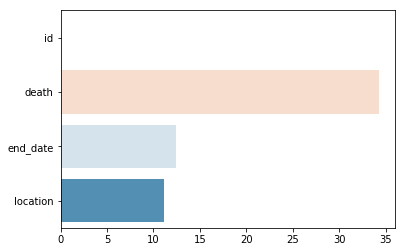

In [7]:
sns.barplot(data=conflict_percentages_nan, palette='RdBu',orient='h')

In [60]:
deaths_pd = conflicts.select("id","title","death","categories").toPandas().set_index('id')

In [61]:
deaths_pd['n_death'] = 0

In [62]:
def extract_deaths(_raw_str):    
    raw_str = re.sub(r'{.*?}','',str(_raw_str)) # questo è estremo, ne abbiamo veramente bisogno?
    raw_str = re.sub(r'isbn=\d{1,99}|{isbn[|]\d.*?}', '', raw_str)
    raw_str = re.sub(r"(?:(?:https?|ftp):\/\/|\b(?:[a-z\d]+\.))(?:(?:[^\s()<>]+|\((?:[^\s()<>]+|(?:\([^\s()<>]+\)))?\))+(?:\((?:[^\s()<>]+|(?:\(?:[^\s()<>]+\)))?\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))?", '', raw_str)
    raw_str = re.sub(r"\|\d{1,9}\||\|\d{1,9}\.\d{1,9}em\||\d{1,9}\.\d{1,9}em\||page.\d{1,9}|p\..\d{1,9}",'',raw_str)
    raw_str = raw_str.replace(".",",")
    raw_str = raw_str.replace("+","")
    regex_nbrs = re.compile(r"\d{1,9}((,|')\d{3})*(\.\d+)?")
    regex_rngs = re.compile(r"\d{1,9}((,|')\d{3})(.\d+)?([-–]| to | [-–] | [-–])\d{1,9}((,|')\d{3})([,']\d+)?")
    allExtr = [];
    
    if(raw_str == 0):
        return 0;
    for match in regex_nbrs.finditer(raw_str):
        allExtr.append(match.group(0))
        
    if(len(allExtr) < 1):
        return 0
        
    rng1 = -1
    rng2 = -1
    for match in regex_rngs.finditer(raw_str):
        rng = match.group(0)
        rng_split = (rng.replace(',','')
                        .replace("'","")
                        .replace("–","-")
                        .replace(" - ","-")
                        .replace(" to ","-").split("-"))
        rng1 = int(rng_split[0])
        rng2 = int(rng_split[1])
        if(rng1>=rng2):
            continue
            
        rng_sum = str(int((int(rng_split[0])+int(rng_split[1]))/2));
        allExtr.append(rng_sum)
        
    #cleaning: 
    #allExtr = [ x for x in allExtr if "." not in x ]
    allExtr = [extr.replace(',', '').replace("'","") for extr in allExtr]
    allExtr = [int(i) for i in allExtr]
    allExtr = [ x for x in allExtr if x not in [rng1,rng2] ]
    
    if(len(allExtr) == 1):
        return allExtr[0]
    
    def shouldGetMax(raw_str,lenExtr):
        toExclude = re.compile(r"(at least|total|over [0-9])",re.IGNORECASE)
        if(toExclude.search(raw_str)):
            return True
        if(lenExtr >=5): #5 numero arbitrario
            return True
        return False
    
    if shouldGetMax(raw_str, len(allExtr)):
        return max(allExtr)
    
    return sum(i for i in allExtr)

In [63]:
deaths_pd["n_death"] = deaths_pd["death"].apply(extract_deaths)

In [64]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 50)
deaths_pd[deaths_pd["death"].isnull()].sort_values(by=['n_death'],ascending=False)

,title,death,categories,n_death
id,,,,
35990004,Battle of the Nervasos Mountains,None,military conflict,0
35666325,Occupy the Farm,None,civil conflict,0
33450237,Occupy Eugene,None,civil conflict,0
36287645,Cicero race riot of 1951,None,civil conflict,0
34536072,2011–12 Mauritanian protests,None,civil conflict,0
202304,Protests against the Iraq War,None,civil conflict,0
56448193,Kasganj violence,None,civil conflict,0
48754233,Siege of Mandsaur,None,military conflict,0
312905,Lebanese Civil War,None,military conflict,0


In [44]:
deaths_pd.loc[[47417586]]

,title,death,n_death
id,,,
47417586,Battle of Demotika,4.000 killed,0


C:\Users\Pietro\AppData\Local\conda\conda\envs\ada\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


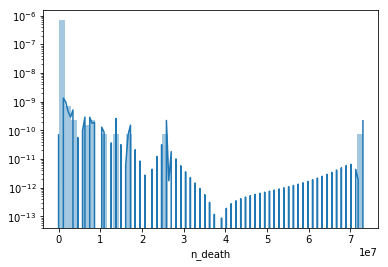

In [31]:
ax = sns.distplot(deaths_pd[deaths_pd["n_death"] != 0]['n_death']);
ax.set_yscale('log')